In [1]:
!pip install numpy pandas matplotlib seaborn pillow



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Importação de bibliotecas

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display

# Configuração de visualização
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Definir caminho base
base_path = '/home/gustavson-barros/dermai-system/datasetHAM1000/archive'

# Carregar metadados

In [3]:
metadata_path = os.path.join(base_path, 'HAM10000_metadata.csv')
metadata = pd.read_csv(metadata_path)

# Visualizar informações básicas
print("Formato do dataframe:", metadata.shape)
metadata.head()

Formato do dataframe: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# Informações estatísticas básicas
metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [5]:
# Verificar valores nulos
metadata.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

# Análise Exploratória de Dados (EDA)

## Distribuição das Classes

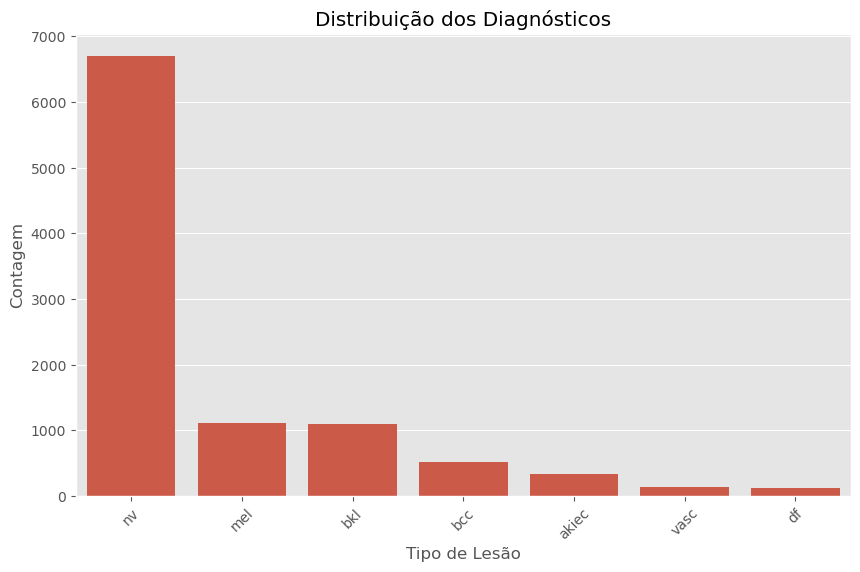

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [7]:
# Contagem por diagnóstico
dx_counts = metadata['dx'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=dx_counts.index, y=dx_counts.values)
plt.title('Distribuição dos Diagnósticos')
plt.xlabel('Tipo de Lesão')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()

dx_counts

# Distribuição por Localização

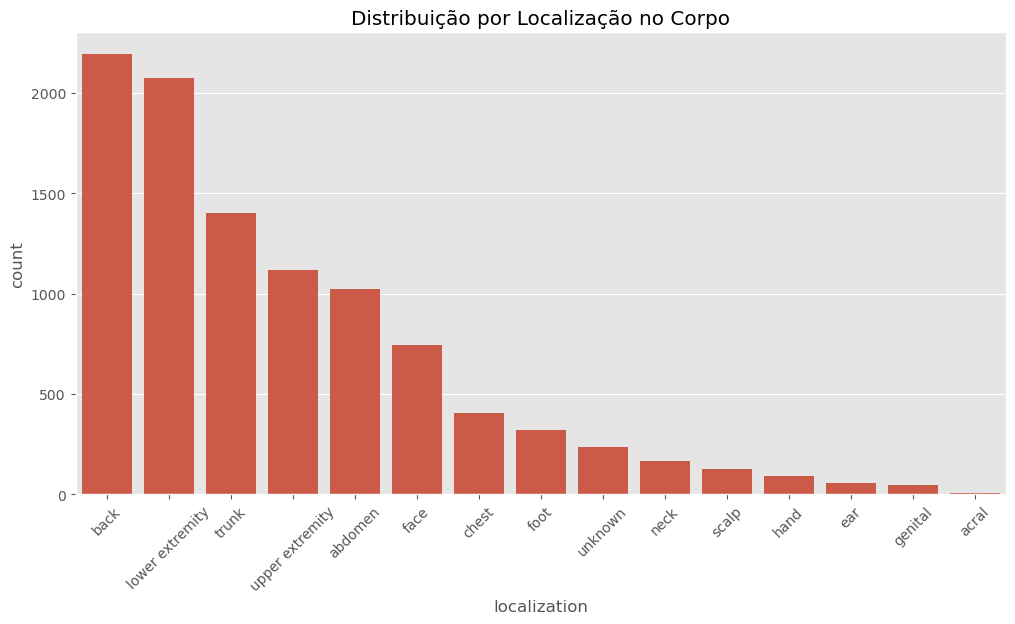

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(x='localization', data=metadata, 
              order=metadata['localization'].value_counts().index)
plt.title('Distribuição por Localização no Corpo')
plt.xticks(rotation=45)
plt.show()

# Distribuição por Idade

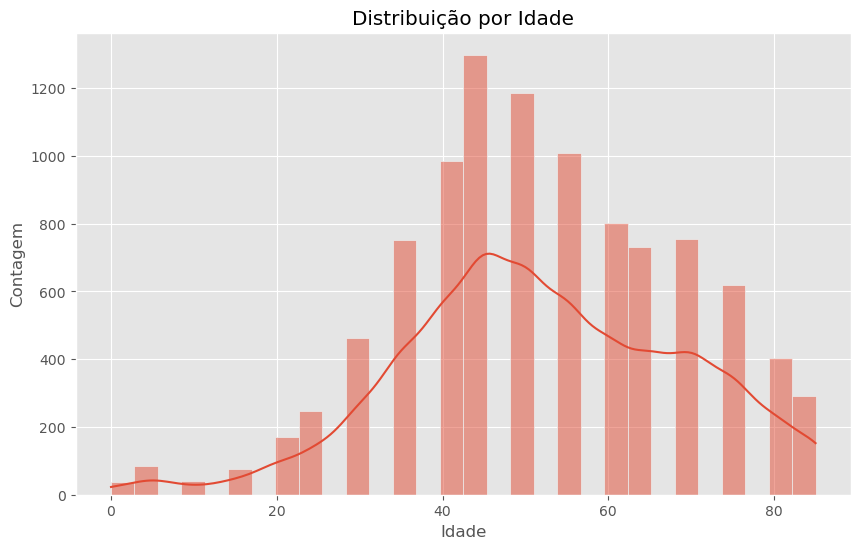

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(metadata['age'].dropna(), bins=30, kde=True)
plt.title('Distribuição por Idade')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()

# Relação entre Variáveis

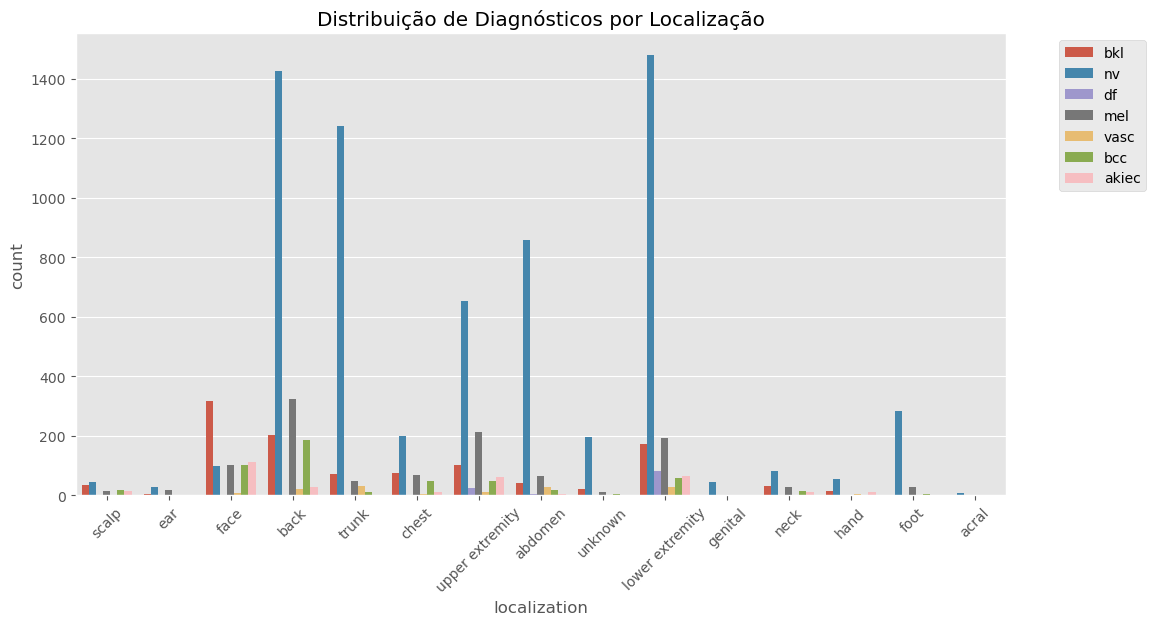

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='localization', hue='dx', data=metadata)
plt.title('Distribuição de Diagnósticos por Localização')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Localização das Imagens

In [11]:
# Função para encontrar imagens nas subpastas
def find_image_path(image_id):
    possible_folders = [
        'ham10000_images_part_1',
        'ham10000_images_part_2',
        'HAM10000_images_part_1',
        'HAM10000_images_part_2'
    ]
    
    for folder in possible_folders:
        img_path = os.path.join(base_path, folder, f"{image_id}.jpg")
        if os.path.exists(img_path):
            return img_path
    return None

# Testar a função
sample_image = metadata.iloc[0]['image_id']
print(f"Exemplo de busca para {sample_image}:")
print(find_image_path(sample_image))

Exemplo de busca para ISIC_0027419:
/home/gustavson-barros/dermai-system/datasetHAM1000/archive/ham10000_images_part_1/ISIC_0027419.jpg


In [12]:
# Adicionar coluna com caminhos das imagens
metadata['image_path'] = metadata['image_id'].apply(find_image_path)

# Verificar quantas imagens foram encontradas
found = metadata['image_path'].notnull().sum()
print(f"Imagens encontradas: {found}/{len(metadata)} ({found/len(metadata):.2%})")

# Filtrar apenas registros com imagens encontradas
valid_metadata = metadata[metadata['image_path'].notnull()].copy()

Imagens encontradas: 10015/10015 (100.00%)


# Visualização de Amostras de Imagens

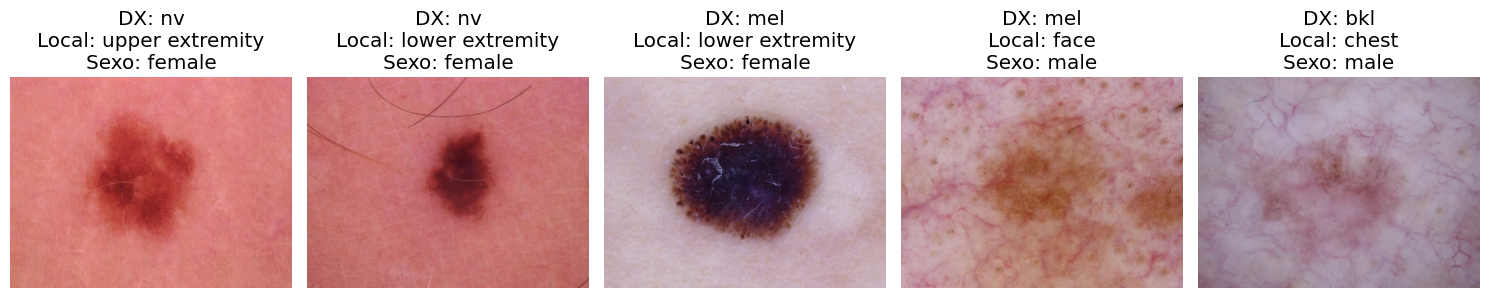

In [13]:
# Função para visualizar amostras aleatórias
def show_random_samples(n=5):
    samples = valid_metadata.sample(n)
    
    plt.figure(figsize=(15, 8))
    for i, (idx, row) in enumerate(samples.iterrows(), 1):
        img = Image.open(row['image_path'])
        
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.title(f"DX: {row['dx']}\nLocal: {row['localization']}\nSexo: {row['sex']}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar 5 amostras aleatórias
show_random_samples(5)

# Pré-processamento e Preparação para Modelagem

## Mapeamento de Labels

In [15]:
# Criar mapeamento de classes
label_mapping = {
    'akiec': 0,  # carcinoma de células escamosas
    'bcc': 1,    # carcinoma basocelular
    'bkl': 2,    # lesão benigna semelhante a queratose
    'df': 3,     # dermatofibroma
    'mel': 4,    # melanoma
    'nv': 5,     # nevo melanocítico
    'vasc': 6    # lesões vasculares
}

valid_metadata['label'] = valid_metadata['dx'].map(label_mapping)

# Verificar distribuição
valid_metadata['label'].value_counts().sort_index()

label
0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
Name: count, dtype: int64

# Divisão Treino/Teste

In [16]:
from sklearn.model_selection import train_test_split

# Dividir em treino e teste (80/20)
train_df, test_df = train_test_split(
    valid_metadata,
    test_size=0.2,
    stratify=valid_metadata['label'],
    random_state=42
)

print(f"Treino: {len(train_df)} imagens")
print(f"Teste: {len(test_df)} imagens")

# Salvar divisões para referência
train_df.to_csv(os.path.join(base_path, 'train_metadata.csv'), index=False)
test_df.to_csv(os.path.join(base_path, 'test_metadata.csv'), index=False)

Treino: 8012 imagens
Teste: 2003 imagens


# Balanceamento de Classes

In [18]:
# Verificar desbalanceamento
class_counts = train_df['label'].value_counts()
class_counts

label
5    5364
4     890
2     879
1     411
0     262
6     114
3      92
Name: count, dtype: int64

In [19]:
# Opção 1: Usar pesos de classe
class_weights = {i: 1./count for i, count in enumerate(class_counts)}
class_weights = {k: v / sum(class_weights.values()) * len(class_weights) for k, v in class_weights.items()}
class_weights

{0: 0.046049386276040875,
 1: 0.27753809885919467,
 2: 0.28101127188246106,
 3: 0.6009949099384021,
 4: 0.9427820915445926,
 5: 2.1667448068831865,
 6: 2.684879434616122}

# Preparação de Data Generators

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurar augmentation para treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # usar 20% do treino para validação
)

# Configurar generator para teste (sem augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


def create_generator(dataframe, generator, batch_size=32, shuffle=True):
    return generator.flow_from_dataframe(
        dataframe=dataframe,
        x_col='image_path',  
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=shuffle
    )

# Criar generators
batch_size = 32

train_generator = create_generator(
    train_df,
    train_datagen,
    batch_size=batch_size,
    shuffle=True
)

val_generator = create_generator(
    train_df,
    train_datagen,
    batch_size=batch_size,
    shuffle=True
)

test_generator = create_generator(
    test_df,
    test_datagen,
    batch_size=batch_size,
    shuffle=False
)

Found 8012 validated image filenames.
Found 8012 validated image filenames.
Found 2003 validated image filenames.


# Verificação Final

Formato do batch de imagens: (32, 224, 224, 3)
Formato do batch de labels: (32,)


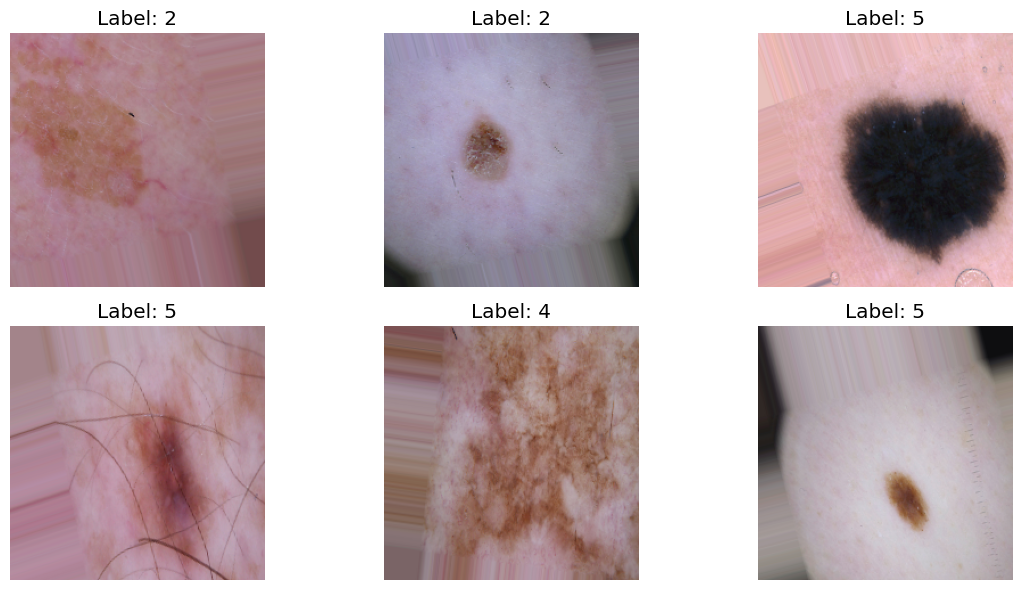

In [22]:
# Verificar uma batch do train_generator
x_batch, y_batch = next(train_generator)

print("Formato do batch de imagens:", x_batch.shape)
print("Formato do batch de labels:", y_batch.shape)

# Visualizar algumas imagens do batch
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {y_batch[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Análise dos Arquivos HMNIST

In [24]:
# Carregar um dos datasets HMNIST para análise rápida
hmnist_28_rgb = pd.read_csv(os.path.join(base_path, 'hmnist_28_28_RGB.csv'))

print("Formato do HMNIST 28x28 RGB:", hmnist_28_rgb.shape)
hmnist_28_rgb.head()

Formato do HMNIST 28x28 RGB: (10015, 2353)


pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  pixel0010  pixel0011  \
0        197        154        185        202        162        192   
1        123         93        126        158        128        158   
2        201        142        160        206        149        165   
3        143        103        119        171        125        134   
4        215        162        191        225        179        214   

   pixel0012  pixel0013  pixel0014  pixel0015  pixel0016  pixel0017  \
0        208        165        201        209        165        205   
1        172        136        162        175        134        157   
2        207        149        159        209        156        164   
3        177        118        123        190        137        146   
4        232        189        222        235        193        219   

   pixel0018  pixel0019  pixel0020  pixel0021  pixel0022  pixel0023  \
0        208        165        194        212        169        198   
1        177        126        158        186        138        163   
2        202        136        130        200        133        129   
3        192        127        143        200        141        162   
4        234        191        206        238        200        219   

   pixel0024  pixel0025  pixel0026  pixel0027  pixel0028  pixel0029  \
0        216        181        204        216        178        204   
1        197        153        187        198        153        186   
2        208        146        157        212        159        167   
3        207        156        170        202        144        151   
4        244        213        240        243        213        239   

   pixel0030  pixel0031  pixel0032  pixel0033  pixel0034  pixel0035  \
0        215        172        205        217        173        209   
1        203        168        206        205        169        204   
2        214        157        168        211        143        150   
3        202        138        155        212        159        177   
4        242        210        238        244        216        241   

   pixel0036  pixel0037  pixel0038  pixel0039  pixel0040  pixel0041  \
0        217        166        202        214        161        202   
1        207        164        199        205        162        200   
2        215        148        169        213        150        176   
3        211        155        172        211        149        163   
4        247        224        244        246        221        242   

   pixel0042  pixel0043  pixel0044  pixel0045  pixel0046  pixel0047  \
0        217        171        207        218        172        205   
1        206        166        185        209        163        189   
2        203        138        150        194        121        124   
3        203        136        144        204        137        156   
4        246        222        243        245        221        242   

   pixel0048  pixel0049  pixel0050  pixel0051  pixel0052  pixel0053  \
0        215        164        193        211        163        189   
1        208        165        190        203        156        183   
2        195        122        125        189        114        118   
3        209        149        180        206        144        165   
4        249        235        253        249        233        247   

   pixel0054  pixel0055  pixel0056  pixel0057  pixel0058  pixel0059  \
0        204        154        176        204        153        181   
1        198      

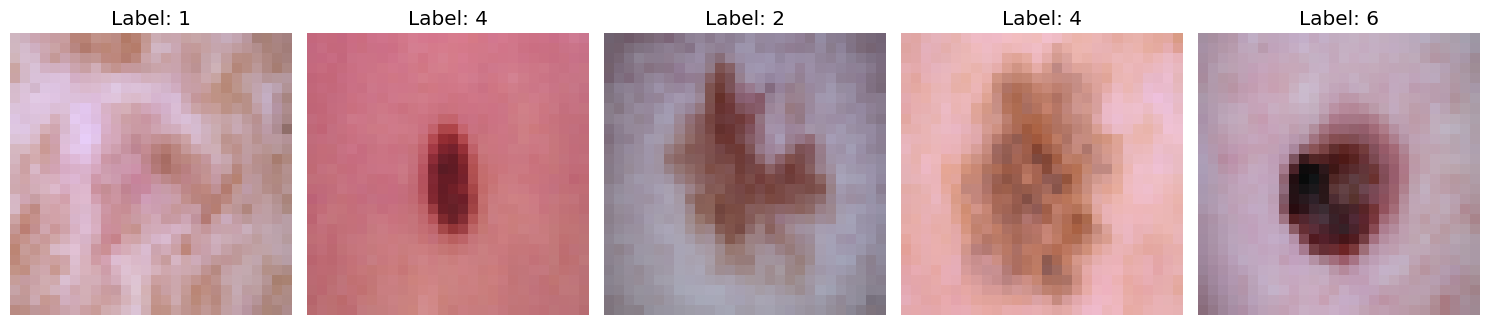

In [25]:
# Visualizar algumas imagens do HMNIST
def show_hmnist_samples(df, n=5):
    samples = df.sample(n)
    
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(samples.iterrows(), 1):
        # Última coluna é o label
        pixels = row.values[:-1]
        label = row.values[-1]
        
        # Reformatar para imagem 28x28x3 (RGB)
        img = pixels.reshape(28, 28, 3)
        
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_hmnist_samples(hmnist_28_rgb, 5)